# Homework08

Exercises to practice pandas, data analysis and classification

## Goals

- Understand the effects of pre-processing data
- Get familiar with the ML flow: encode -> normalize -> train -> evaluate
- Understand the difference between regression and classification tasks
- Build intuition for different classification models

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [1]:
!wget -q https://github.com/PSAM-5020-2025F-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025F-A/5020-utils/raw/main/src/image_utils.py

!wget -qO- https://github.com/PSAM-5020-2025F-A/5020-utils/releases/latest/download/0801-500.tar.gz | tar xz

In [2]:
import pandas as pd
import PIL.Image as PImage

from os import listdir, path

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from data_utils import classification_error, display_confusion_matrix, regression_error

from image_utils import get_pixels, make_image

from Homework08_utils import CamUtils

## Classification

The dataset we are going to use has images from $25$ different security cameras, and our task is to separate them by camera. Some of the cameras move, some of them don't, and there are more than $1000$ images, so there's no way we want to do this by hand.

### Loading Data

If we look at the images in `./data/image/0801-500/train/`, we'll notice that they are named and organized in a very particular way. They're all in the same directory and the first part of their filename specifies which camera they came from. Even though those `ids` are numbers, they're not sequential, so we'll use some helper functions to extract a unique `label` from their filenames.

This is exactly what the `OrdinalEncoder` class does, but since we only have to encode this one column, we'll do it by hand while we read the files in.

Alternatively, we could try using a `OneHotEncoder`, but since we have $25$ cameras, adding $25$ sparse columns to our dataset might confuse our classification fitting.

In [3]:
# this creates a list of all the files in a given directory, that end in .jpg
train_files = [f for f in listdir("./data/image/0801-500/train") if f.endswith(".jpg")]

In [5]:
# TODO: check and see what is inside the list here
train_files

['17-40.jpg',
 '31-13.jpg',
 '07-85.jpg',
 '26-29.jpg',
 '02-48.jpg',
 '06-53.jpg',
 '02-36.jpg',
 '07-42.jpg',
 '25-83.jpg',
 '15-49.jpg',
 '17-51.jpg',
 '21-51.jpg',
 '22-48.jpg',
 '27-47.jpg',
 '27-15.jpg',
 '15-48.jpg',
 '24-10.jpg',
 '12-40.jpg',
 '17-57.jpg',
 '31-20.jpg',
 '02-21.jpg',
 '15-13.jpg',
 '10-50.jpg',
 '28-74.jpg',
 '12-19.jpg',
 '24-44.jpg',
 '25-69.jpg',
 '03-20.jpg',
 '28-78.jpg',
 '07-09.jpg',
 '27-20.jpg',
 '11-04.jpg',
 '06-30.jpg',
 '24-01.jpg',
 '13-09.jpg',
 '13-26.jpg',
 '02-40.jpg',
 '19-17.jpg',
 '21-35.jpg',
 '07-11.jpg',
 '13-04.jpg',
 '02-24.jpg',
 '07-48.jpg',
 '31-02.jpg',
 '31-15.jpg',
 '28-77.jpg',
 '06-47.jpg',
 '09-06.jpg',
 '26-16.jpg',
 '01-40.jpg',
 '22-58.jpg',
 '25-65.jpg',
 '27-08.jpg',
 '07-12.jpg',
 '02-47.jpg',
 '03-69.jpg',
 '03-36.jpg',
 '06-36.jpg',
 '10-49.jpg',
 '23-41.jpg',
 '24-50.jpg',
 '01-07.jpg',
 '11-87.jpg',
 '19-62.jpg',
 '19-84.jpg',
 '09-41.jpg',
 '09-65.jpg',
 '19-30.jpg',
 '11-60.jpg',
 '09-30.jpg',
 '15-07.jpg',
 '09-4

Now we'll read the image pixels and extract their labels. `CamUtils.get_label()` is the helper function we'll use to "encode" and return a label id based on the filename.

In [4]:
pixel_data = []
label_data = []

for fname in train_files:
  label = CamUtils.get_label(fname)
  img = PImage.open(path.join("./data/image/0801-500/train", fname))
  pixel_data.append(get_pixels(img))
  label_data.append(label)

In [6]:
# TODO: check if labels got extracted correctly by looking at 
#       the first few items of the label list and the filename list
print("first items in label list:",label_data[:10])
# the label list appears to have extracted the camera IDs (first 2 digits of filename)

print("first items in filename list:",train_files[:10])

# the filename list has the full filenames

first items in label list: [13, 24, 5, 21, 1, 4, 1, 5, 20, 12]
first items in filename list: ['17-40.jpg', '31-13.jpg', '07-85.jpg', '26-29.jpg', '02-48.jpg', '06-53.jpg', '02-36.jpg', '07-42.jpg', '25-83.jpg', '15-49.jpg']


The labels and the filenames won't match exactly since labels start at $0$ and the filenames start at $01$ and skip some numbers.

We can open some images from pixels, just to make sure we loaded them correctly (they're squares, so no need to specify `width`):

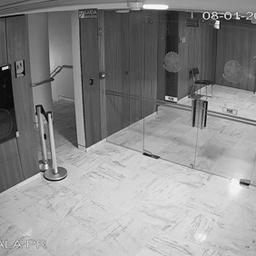

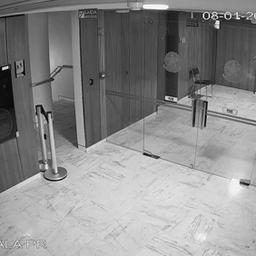

In [7]:
display(make_image(pixel_data[0]))
display(make_image(pixel_data[10]))

And now might not be a bad time to peek into the `data/image/0801-500/` directories to see what's inside them and what the images look like.... and get to know the data...

### DataFrame it

Let's put our raw pixel data into a `DataFrame`, and create a column for storing each image's label.

(this next cell might take a while to run)

In [8]:
train_df = pd.DataFrame(pixel_data)
train_df["label"] = label_data

Let's inspect our `DataFrame`:

In [13]:
print(train_df.head())

# getting the min and max values of each column
print ("min values:\n", train_df.min())
print ("max values:\n", train_df.max())

     0    1    2    3    4    5    6    7    8    9  ...  65527  65528  65529  \
0   93   95   96   98   99   98   97   97   96   97  ...    182    183    177   
1   67   70   74   78   80   80   80   79   82   82  ...     70     61     68   
2   53   54   54   54   55   58   64   68   62   61  ...    172    170    174   
3  104  104  104  104  104  104  104  104  105  105  ...    120    114    115   
4   68   68   68   70   71   73   75   76   72   71  ...    130    130    132   

   65530  65531  65532  65533  65534  65535  label  
0    176    181    181    176    174    176     13  
1     63     55     71     96     91     65     24  
2    179    181    180    179    180    182      5  
3    115    113    112    112    114    116     21  
4    133    133    132    131    132    134      1  

[5 rows x 65537 columns]
min values:
 0        0
1        0
2        0
3        0
4        0
        ..
65532    0
65533    0
65534    0
65535    0
label    0
Length: 65537, dtype: int64
max val

### Insight

<span style="color:hotpink">
Does anything stand out as peculiar about the feature values in our <code>DataFrame</code>?<br>
Do we have to encode or scale our data?<br>
Why? Or, why not?<br>
</span>

<span style="color:hotpink;">
The DataFrame contains 65,536 columns representing the pixels of each image, plus a "label" column. Each column corresponds to a single pixel value, and each row represents one image. The pixel values range from 0 to 255, which correspond to grayscale pixel levels. What stands out is the very large number of features per image. 

Since all features are already numeric and on the same scale, we don't need to encode them. However, we can scale them to improve model performance by expressing each data point in terms of its aggregate characteristics and therefore reducing the model's sensitivity to outliers.
</span>

### Test Files

If that worked, repeat the process for the test files inside the `./data/image/0801-500/test/` directory.

We can almost use the exact same steps as we did above to create a `DataFrame`, the only difference being that we don't have labels for these images.

In [16]:
# TODO: create a list of files in the test/ directory
test_files = [f for f in listdir("./data/image/0801-500/test") if f.endswith(".jpg")]

# TODO: check its length and content
print("number of test files:", len(test_files))
print("first 5 test files:", test_files[:5])

test_pixel_data = []

# TODO: loop over files and load their pixels into a list
for fname in test_files:
  img = PImage.open(path.join("./data/image/0801-500/test", fname))
  test_pixel_data.append(get_pixels(img))
  
# TODO: load into DataFrame (this might take 20 - 30 seconds)
test_df = pd.DataFrame(test_pixel_data)

number of test files: 1573
first 5 test files: ['14733495.jpg', '5690769.jpg', '6168839.jpg', '10816147.jpg', '7977395.jpg']


: 

Check the `DataFrame`

In [ ]:
test_df.head()

Looks like data!!

We could train a `RandomForestClassifier` directly on this `DataFrame` and see what would happen, but my guess is that Python runs out of memory and crashes our tab/browser/computer...

We'll use _projection_ to reduce the number of dimensions in our dataset. Projection is when we just drop some of the columns in our dataset. 

Which columns ? That's up to us.

Let's first try using the first $N$ columns/features where $N$ is a number around $10$.

This is how we get the first $N$ columns from a `DataFrame`:

In [ ]:
# split input and output features
NUM_FEATURES = 10
chosen_columns = train_df.columns[:NUM_FEATURES]
train_features = train_df[chosen_columns]

out_features = train_df["label"]

# also separate test dataset features
test_features = test_df[chosen_columns]

From our [Week 08](https://github.com/PSAM-5020-2025F-A/WK08) notebook, we can create a classification model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (not needed! done! ⚡️)
3. Normalize the data (not needed! done! 🍾)
4. Separate the outcome variable and the input features (done! ☀️)
5. Create a model using chosen features
6. Run model on training data and measure error*
7. Run model on test data, measure error*, plot predictions, interpret results

We could use the same `regression_error()` function we used previously to measure the error of our classifier model, but this could lead to $2$ issues. First, we don't have labels for the images in the test dataset, and second, the regression error reported might be higher than it actually is because an image with label $0$ that gets mislabeled as $5$ will count as being more wrong than if it was mislabeled $2$. And we don't want that. We just want to get the percentage of classifications that our model gets correctly.

To simplify calculating the classification accuracy we can use the `CamUtils.classification_accuracy()` function. This function takes $2$ parameters, a list of files and a list of predictions. It will work with the test and train datasets and will calculate a more meaningful accuracy value than the one returned by `regression_error()`.

In [ ]:
# TODO: create a brand new classifier
# TODO: fit the model
# TODO: run predictions
# TODO: measure classification accuracy
CamUtils.classification_accuracy(train_files, train_predictions)

That should look promising. Let's run this on our test dataset.

Remember we already separated the test data features into a variable called `test_features` above.

Now we just have to run the prediction and measure accuracy.

In [ ]:
# TODO: run predictions on test data
# TODO: measure classification accuracy

### Interpretation

Using just the first $10$ pixels of the image the classifier is able to label most of the images correctly.

<span style="color:hotpink">
How can we improve this classifier? How does the number of features affect the classification accuracy of the test data?<br>
How does the choice of pixels affect the accuracy?<br><br>
If you're curious, repeat the modeling above, but using the <code>SVC</code> classifier instead of <code>RandomForest</code>.<br>How does the choice of modeling technique affect the accuracy?<br><br>
Experiment with some of these parameters and explain your findings below.
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>